In [1]:
import pickle as pkl
import numpy as np
from itertools import chain
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from scipy.stats import norm

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import make_brier_skill_plot, make_brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot, make_twcrps_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram, make_reliability_diagram_sklearn, make_reliability_and_sharpness
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf, plot_weight_mixture, plot_forecast_pdf_i

2024-04-05 14:16:13.239566: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 14:16:13.266944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 14:16:13.266966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 14:16:13.267664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 14:16:13.271841: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 14:16:13.272135: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 100)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3978281]
  b_tn: [ 0.96437526 -0.03847758 -0.14859994  0.03270449  0.02480017]
  c_tn: [1.3522791]
  d_tn: [1.0781002]
Features: wind_speed, press, kinetic, humid, geopot, spatial_variance
Location features: wind_speed, press, kinetic, humid, geopot
Scale features: spatial_variance
Number of features: 6
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.029999999329447746



In [3]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test = get_tensors(base_model.neighbourhood_size, base_model.all_features, test_fold, ignore)
X_test = base_model.normalize_features(X_test)

In [4]:
gev = load_model(folder + 'gev/gev_twcrps_mean13.0_std2.0_epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')

tn_M13_STD2 = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std2.0_epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')

ml_tn_gev_M13_STD2 = load_model(folder + 'mixture_linear/ml_tn_gev_twcrps_mean13.0_std2.0_epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')

ml_tn_gev_M13_STD2_C2 = load_model(folder + 'mixture_linear/ml_tn_gev_twcrps_mean13.0_std2.0_constant0.019999999552965164_epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')

ml_tn_tn_M13_STD2_C2 = load_model(folder + 'mixture_linear/ml_tn_tn_twcrps_mean13.0_std2.0_constant0.019999999552965164_epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')

ml_tn_tn_M13_STD2_C3 = load_model(folder + 'mixture_linear/ml_tn_tn_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_1_2_mean0_1_2_3_4_std5_.pkl')

tn_all_features = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_1_2_mean0_1_2_3_4_5_std0_1_2_3_4_5_.pkl')

tn_almost_all = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_1_2_mean0_1_2_3_4_std0_1_2_3_4_5_.pkl')

ml_tn_gev_M13_STD2_C3_more = load_model(folder + 'mixture_linear/ml_tn_gev_twcrps_mean13.0_std2.0_constant0.029999999329447746_epochs600_folds_1_2_mean0_1_2_3_4_std0_1_2_3_4_5_.pkl')

ml_tn_gev_M13_STD2_C5 = load_model(folder + 'mixture_linear/ml_tn_gev_twcrps_mean13.0_std2.0_constant0.05000000074505806_epochs600_folds_1_2_mean0_1_2_3_4_std0_1_2_3_4_5_.pkl')

ml_tn_ln_M13_STD2_C5 = load_model(folder + 'mixture_linear/ml_tn_ln_twcrps_mean13.0_std2.0_constant0.05000000074505806_epochs600_folds_1_2_mean0_1_2_3_4_std0_1_2_3_4_5_.pkl')

ml_tn_tn_M13_STD2_C5 = load_model(folder + 'mixture_linear/ml_tn_tn_twcrps_mean13.0_std2.0_constant0.05000000074505806_epochs600_folds_1_2_mean0_1_2_3_4_std0_1_2_3_4_5_.pkl')

models = {#"gev": gev, 
          #"tn_M13_STD2": tn_M13_STD2, 
          #"ml_tn_gev_M13_STD2": ml_tn_gev_M13_STD2,
            #"ml_tn_gev_M13_STD2_C2": ml_tn_gev_M13_STD2_C2, 
            #"ml_tn_tn_M13_STD2_C2": ml_tn_tn_M13_STD2_C2,
            #"ml_tn_tn_M13_STD2_C3": ml_tn_tn_M13_STD2_C3,
            #"tn_all_features": tn_all_features,
            "tn_almost_all": tn_almost_all,
            "ml_tn_gev_M13_STD2_C3_more": ml_tn_gev_M13_STD2_C3_more,
            "ml_tn_gev_M13_STD2_C5": ml_tn_gev_M13_STD2_C5,
            "ml_tn_ln_M13_STD2_C5": ml_tn_ln_M13_STD2_C5, 
            #"ml_tn_tn_M13_STD2_C5": ml_tn_tn_M13_STD2_C5,
}

Using given parameters for Generalized Extreme Value distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distributi

In [6]:
ylim = [-0.1, 0.2]
values = np.linspace(0, 20, 200)
make_brier_skill_plot(base_model, models, X_test, y_test, values, ylim=ylim)

KeyboardInterrupt: 

In [13]:
print("Base model CRPS: ", base_model.CRPS(X_test, y_test, 10000).numpy())
for name, model in models.items():
    print(name, "CRPS: ", model.CRPS(X_test, y_test, 10000).numpy())

Base model CRPS:  0.8903243
tn_almost_all CRPS:  0.88586134
ml_tn_gev_M13_STD2_C3_more CRPS:  0.8864303
ml_tn_gev_M13_STD2_C5 CRPS:  0.8862065
ml_tn_ln_M13_STD2_C5 CRPS:  0.88482517
ml_tn_tn_M13_STD2_C5 CRPS:  0.91914946


In [8]:
threshold = 13
print("Base model twCRPS: ", base_model.twCRPS(X_test, y_test, threshold, 10000).numpy())
for name, model in models.items():
    print(name, "twCRPS: ", model.twCRPS(X_test, y_test, threshold, 10000).numpy())

Base model twCRPS:  0.042125877
tn_almost_all twCRPS:  0.04179194
ml_tn_gev_M13_STD2_C3_more twCRPS:  0.0411279
ml_tn_gev_M13_STD2_C5 twCRPS:  0.040712044
ml_tn_ln_M13_STD2_C5 twCRPS:  0.040396143


In [9]:
samples = 10000
print("Base model myScore: ", base_model.CRPS(X_test, y_test, samples).numpy() + base_model.twCRPS(X_test, y_test, 12, samples).numpy() + base_model.twCRPS(X_test, y_test, 15, samples).numpy())
for name, model in models.items():
    print(name, "myScore: ", model.CRPS(X_test, y_test, samples).numpy() + model.twCRPS(X_test, y_test, 12, samples).numpy() + model.twCRPS(X_test, y_test, 15, samples).numpy())

Base model myScore:  0.970063
tn_almost_all myScore:  0.96518624
ml_tn_gev_M13_STD2_C3_more myScore:  0.9642393
ml_tn_gev_M13_STD2_C5 myScore:  0.96352565
ml_tn_ln_M13_STD2_C5 myScore:  0.961488


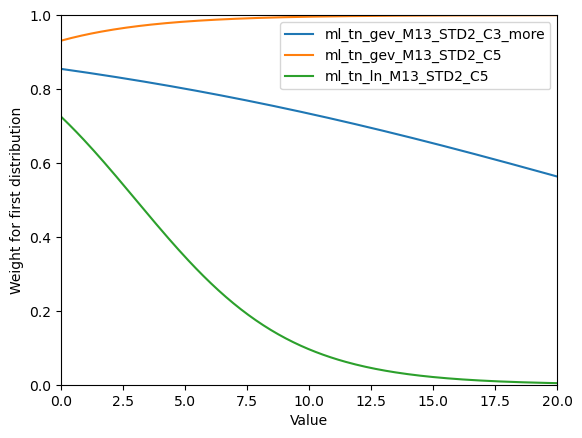

In [6]:
plot_weight_mixture(models, values)

KeyboardInterrupt: 

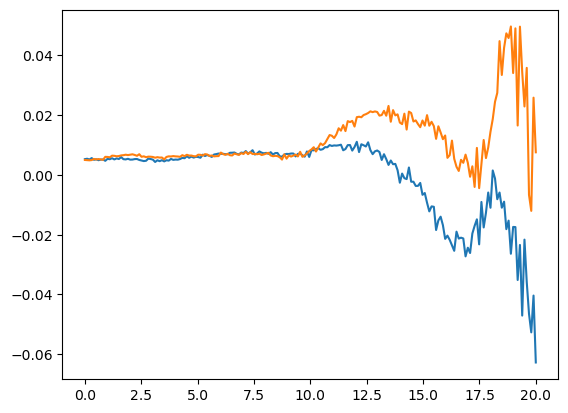

In [14]:
make_twcrpss_plot(base_model, models, X_test, y_test, values, ylim=ylim, sample_size=10000)

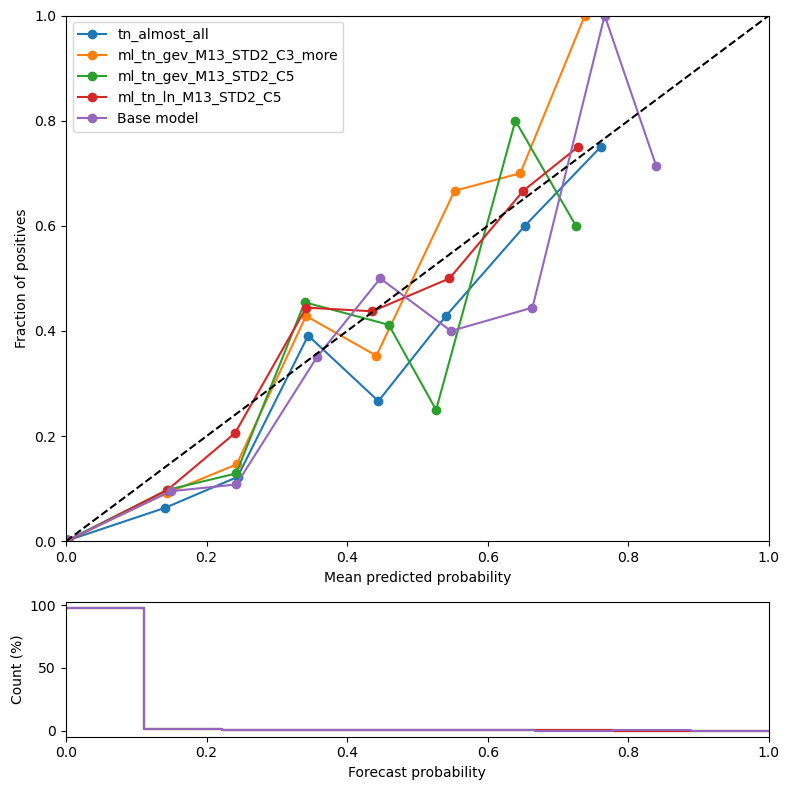

In [20]:
t=16
make_reliability_and_sharpness(models, X_test, y_test, t, base_model=base_model)

probabilities contain nan
There are 104 values in the PIT diagram


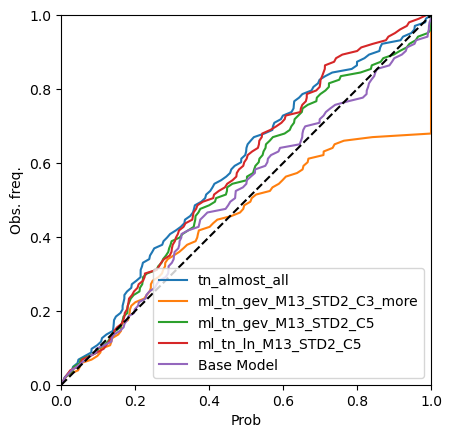

In [6]:
t = 15
make_cpit_diagram_emos(models, X_test, y_test, t=t, base_model=base_model)